# Generating centroids within Fremont neighborhoods

### Goal of the notebook

We'll slice neighborhood polygons into smaller parts by using `geovoronoi` module - this creates Voronoi diagrams within boundaries of each of the neighborhood boundaries.

***

**Outputs:**

Internal Centroid Zones:
- neighborhoods_centroid_zones.csv

**Inputs:**

Fremont neighborhoods:
- Neighborhoods.shp

***

In [1]:
# --- Global variables

# Setting up the Coordinate Reference Systems up front in the necessary format.
epsg = 4326
crs_degree = {'init': 'epsg:4326'} # CGS_WGS_1984 (what the GPS uses)

# --- Paths

# Root path of Fremont Dropbox
import os
import sys
# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from fremontdropbox import get_dropbox_location
# Root path of the Dropbox business account
dbx = get_dropbox_location()

# Temporary! Location of the folder where the restructuring is currently happening
data_path = dbx + '/Private Structured data collection'
aux_path = data_path+'/Data processing/Auxiliary files'

# Processing output path
output_path = aux_path + '/Demand/OD demand'

***

## 2. Split neighborhoods into parts

There are 28 Fremont neighborhoods, but our internal starting and ending nodes from internal Fremont legs reside only within 12 of them. Here, we'll separate those 12 we are interested in.

In [2]:
from demandutils import neighborhoods_touching_internal_legs

neighborhoods_touching_internal_legs(
    data_path+'/Data processing/Raw/Demand/OD demand/Fremont neighborhoods/Neighborhoods.shp',
    aux_path+'/Demand/OD demand/SFCTA demand data/internal_fremont_legs_start_nodes.shp', # int Fremont legs points
    output_path+'/TAZ/neighborhoods_touching_int_points.shp')

Filtered 12 neighborhoods.


### 2.1. Using `geovoronoi` package with randomly generated points within neighborhoods

We're going to use `geovoronoi` module here to do the splitting. We generate random points within each neighborhood boundaries and they will used as input centroids, from which Voronoi diagrams will be generated.

These Voronoi diagrams will then be converted into `Polygon`s. We'll generate new `GeoDataFrame` which will contain all of the new generated `Polygons` and set `CentroidID` and `NeighborhoodID` to each one of them.

In [3]:
from demandutils import geovor_in_neighborhoods_random_points

geovor_in_neighborhoods_random_points(
    aux_path+'/Demand/OD demand/TAZ/neighborhoods_touching_int_points.shp',
    aux_path+'/Demand/OD demand/SFCTA demand data/internal_fremont_legs_start_nodes.shp',
    output_path+'/TAZ/internal_centroid_zones_random_points.csv')

Created 125 centroids within 12 neighborhoods.


In [4]:
# Visually check internal zones
from demandutils import visual_check_internal_taz

visual_check_internal_taz(aux_path+'/Demand/OD demand/TAZ/internal_centroid_zones_random_points.csv', aux_path+'/Demand/OD demand/SFCTA demand data/internal_fremont_legs_start_nodes.shp')

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'Nodes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…

***

### 2.2. WIP!!! Using `geovoronoi` package with real points from internal Fremont leg within neighborhoods

In [5]:
from demandutils import geovor_in_neighborhoods_real_points

geovor_in_neighborhoods_real_points(
    aux_path+'/Demand/OD demand/TAZ/neighborhoods_touching_int_points.shp',
    aux_path+'/Demand/OD demand/SFCTA demand data/internal_fremont_legs_start_nodes.shp',
    output_path+'/TAZ/internal_centroid_zones_from_real_points.csv')

0    POINT (-121.94962 37.50937)
1    POINT (-121.94493 37.51764)
2    POINT (-121.94508 37.51287)
3    POINT (-121.95432 37.50237)
4    POINT (-121.92959 37.49598)
Name: geometry, dtype: geometry


IndexError: list index out of range

***

# TODO: internal TAZ by k-means clustering

### 2.3. WIP!!! Using K-means clustered points

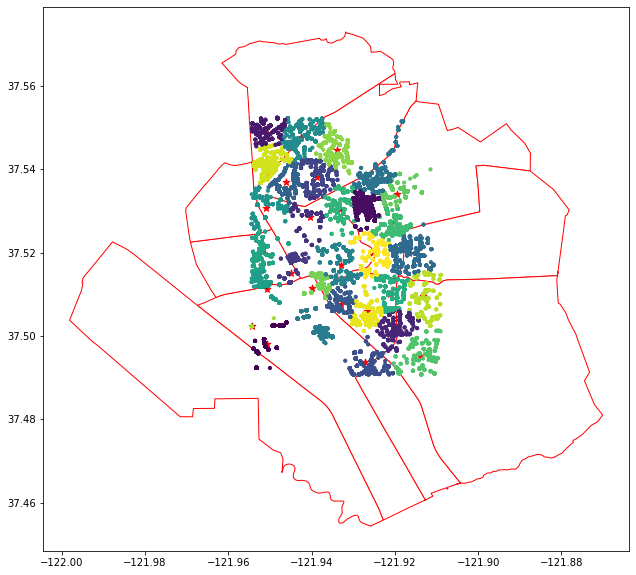

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import geopandas as gpd

neighborhoods_shp = gpd.GeoDataFrame.from_file(aux_path+'/Demand/OD demand/TAZ/neighborhoods_touching_int_points.shp',)
nodes = gpd.GeoDataFrame.from_file(aux_path+'/Demand/OD demand/SFCTA demand data/internal_fremont_legs_start_nodes.shp')

listarray = []
for pp in nodes.geometry:
    listarray.append([pp.x, pp.y])
points = np.array(listarray)


kmeans = KMeans(n_clusters=30)
# Fitting the input data
kmeans = kmeans.fit(points)
# Getting the cluster labels
labels = kmeans.predict(points)
# Centroid values
centroids = kmeans.cluster_centers_


plt.rcParams['figure.figsize'] = (20, 10)
fig, ax = plt.subplots()
ax.set_aspect('equal')

neighborhoods_shp.plot(ax=ax, color='white', edgecolor='red')

# Centroids
plt.scatter(centroids[:,0], centroids[:,1], marker='*', s=50, c='red');

# Point clusters
plt.scatter(points[:,0], points[:,1], marker='o', s=10, c=labels);

plt.show();

***

### Don't forget to copy generated CSV file to correct location for further processing!